In [1]:
from __future__ import print_function

import numpy as np
#import reflexxes
import random
import pandas as pd
from numpy import genfromtxt

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from hmmlearn import hmm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances
import datetime

import pickle

In [2]:
# load  clean data

# load noisy data
org_p = np.loadtxt('../Trajectory/data0503/original_position_list.csv', delimiter=' ')
org_v = np.loadtxt('../Trajectory/data0503/original_velocity_list.csv', delimiter=' ')
nos_p_01 = np.loadtxt('../Trajectory/data0503/position_noise_0.1.csv', delimiter=' ')
nos_p_1 = np.loadtxt('../Trajectory/data0503/position_noise_1.csv', delimiter=' ')
nos_p_2 = np.loadtxt('../Trajectory/data0503/position_noise_2.csv', delimiter=' ')
nos_p_5 = np.loadtxt('../Trajectory/data0503/position_noise_5.csv', delimiter=' ')

traj_lens = np.loadtxt('../Trajectory/data0503/traj_lens.csv', delimiter=' ')
traj_lens = traj_lens.astype(int)

outlier_indices = np.loadtxt('../Trajectory/data/outlier_0.01-c/outlier_indices.csv', delimiter=' ')
outlier_indices = outlier_indices.astype(int)

In [3]:
# reframe dataset as per traj_lens
traj_lens_cumsum = traj_lens.cumsum()
traj_lens_cumsum = np.delete(traj_lens_cumsum, len(traj_lens_cumsum) - 1)

org_p_spl = np.split(org_p, traj_lens_cumsum, axis=0)
org_v_spl = np.split(org_v, traj_lens_cumsum, axis=0)
nos_p_01_spl = np.split(nos_p_01, traj_lens_cumsum, axis=0)
nos_p_1_spl = np.split(nos_p_1, traj_lens_cumsum, axis=0)
nos_p_2_spl = np.split(nos_p_2, traj_lens_cumsum, axis=0)
nos_p_5_spl = np.split(nos_p_5, traj_lens_cumsum, axis=0)

print(f'org_p.size: {len(org_p_spl)}')
print(f'nos_p_01_spl.size: {len(nos_p_01_spl)}')
print(f'nos_p_1_spl.size: {len(nos_p_1_spl)}')
print(f'nos_p_2_spl.size: {len(nos_p_2_spl)}')
print(f'nos_p_5_spl.size: {len(nos_p_5_spl)}')

org_p.size: 100
nos_p_01_spl.size: 100
nos_p_1_spl.size: 100
nos_p_2_spl.size: 100
nos_p_5_spl.size: 100


In [4]:
# try label no. = 10

init_mean = []

# Hui Min CHANGE ME~~ : number of component in each diagonal
num = 5 

for i in range(num):
    for j in range(num):
        for k in range(num):
            init_mean.append([i * (100/num) + (50/num), j * (100/num) + (50/num), k * (100/num) + (50/num)])
#print(init_mean)   

In [6]:
# plot data function
def on_key_press(event):
    if event.key == 'escape':
        plt.close()
        
def original_plot(x, dd, dddx):
    t = np.linspace(0, len(x) * gen.cycle_time, len(x))
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.canvas.mpl_connect('key_press_event', on_key_press)
    ax1.plot(t, x)
    ax1.set_ylabel('position')
    ax1.legend('123', title='DOF #')
    ax2.plot(t, dx)
    ax2.set_ylabel('velocity')
    ax2.legend('123', title='DOF #')
    ax3.plot(t, ddx)
    ax3.set_ylabel('acceleration')
    ax3.legend('123', title='DOF #')
    ax3.set_xlabel('time')
    plt.show()
    
def plot_trajectory(x, title, outliers=[]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.plot3D(xline, yline, zline, 'green')
    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.plot3D(xline, yline, zline, 'red')
    #plt.savefig(title + ".png")
            
def plot_mean(x, title, outliers=[]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.scatter(xline, yline, zline, 'green')
    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.scatter(xline, yline, zline, 'red')
    #plt.savefig(title + ".png")

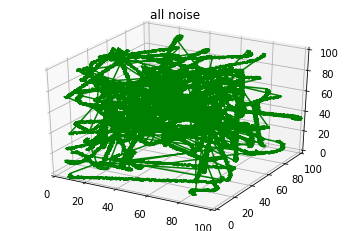

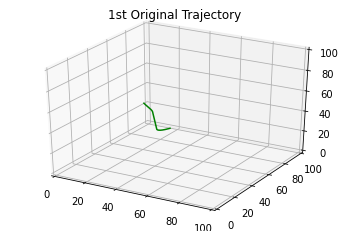

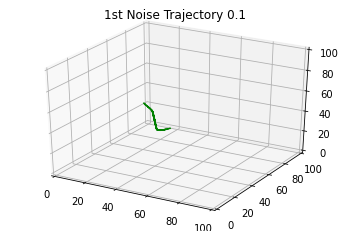

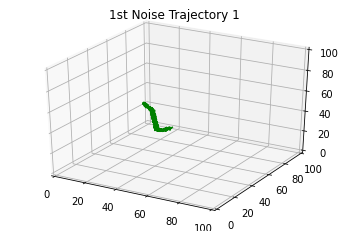

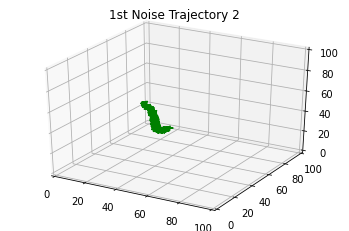

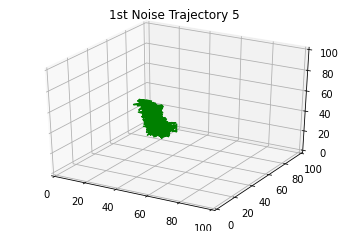

In [7]:
# plot 1st trajectory 
plot_trajectory(nos_p_1, 'all noise')
plot_trajectory(org_p_spl[0], '1st Original Trajectory')
plot_trajectory(nos_p_01_spl[0], '1st Noise Trajectory 0.1')
plot_trajectory(nos_p_1_spl[0], '1st Noise Trajectory 1')
plot_trajectory(nos_p_2_spl[0], '1st Noise Trajectory 2')
plot_trajectory(nos_p_5_spl[0], '1st Noise Trajectory 5')

In [8]:


a = datetime.datetime.now()
HMM_10 = hmm.GaussianHMM(n_components=30, covariance_type="diag", init_params="sct", params="sct", n_iter=len(traj_lens), verbose=True)
#HMM_10.means_ = init_mean

# fit data: change me (org_p) to nos_p_01
HMM_10.fit(nos_p_5, traj_lens)
b = datetime.datetime.now()
print(b-a)

         1     -943648.1714             +nan
         2     -892002.8121      +51645.3593
         3     -821163.0452      +70839.7669
         4     -748397.5947      +72765.4505
         5     -705297.4812      +43100.1136
         6     -699649.8216       +5647.6596
         7     -699232.7610        +417.0605
         8     -699177.2654         +55.4956
         9     -699164.8327         +12.4327
        10     -699157.7638          +7.0689
        11     -699152.9197          +4.8441
        12     -699150.3062          +2.6135
        13     -699148.0837          +2.2225
        14     -699147.0989          +0.9849
        15     -699142.7475          +4.3513
        16     -699117.1997         +25.5478
        17     -699099.2618         +17.9379
        18     -699080.5916         +18.6702
        19     -699079.1414          +1.4502
        20     -699078.8511          +0.2903
        21     -699078.6928          +0.1583
        22     -699078.5639          +0.1289
        23

0:07:11.752270


        33     -699077.0036          +0.0091


In [67]:
# export model
with open("May03_5x5x5.pkl", "wb") as file: pickle.dump(HMM_10, file)
